## TRANSACTION DATA (CREDIT FRAUD) - MACHINE LEARNING

 Sumber dataset : https://drive.google.com/file/d/1sr0k8_k7huFuHiR_C5P_r60VaBDzwoTb/view

Dalam tahap ini, akan di lakukan proses **Classification Machine Learning** terhadap data *transaction.csv*. Dimana data sebelumnya sudah di lakukan pembersihan dari **Null Values** pada tahap **preprocessing** dalam **EDA** sebelumnya, sehingga dalam proses ini hanya terfokus untuk membangun model prediksi. Model yang di gunakan adalah ***LogisticRegression*** dan ***KNNeighbors***. Pembuatan model di lakukan dengan melalui metode pipelining, sehingga hasilnya juga akan cenderung lebih baik. Pembuatan model juga melewati beberapa tahap **feature engineering**, dimana dalam tahap ini, data akan di lakukan uji **normalitas** dan **outliers** checking, **feature selection**, dan **cross-validation**. Dan karena data sangat *imbalanced*, maka nantinya akan di lakukan ***oversampling*** dengan metode ***SMOTE***.


### FEATURE DESCRIPTION :

- accountNumber             = The account number of The customer
- customerId    =  The ID of The customer
- creditLimit               =  The amount of money that can be charged to The debit card
- availableMoney        = The amount of money in The debit card before adjusting for pending charges      
- transactionDateTime       = The transaction timestamp when it happened
- transactionAmount        = The amount of transaction 
- merchantName          = The merchant name of The particular transaction
- acqCountry             = The country where The merchant is located
- merchantCountryCode    = The country code for The specific merchant
- posEntryMode        = a code that tells The processor how The transaction was captured
- posConditionCode   = a code identifying transaction conditions at The point-of-sale or point-of-service
- merchantCategoryCode    = The merchant category/types
- currentExpDate       =  The expiry date of The credit card
- accountOpenDate      = The date when The customer open The credit card
- dateOfLastAddressChange    = The last date when The customer change The credit card address
- cardCVV = The actual card verification value
- enteredCVV       = The entered card verification value
- cardLast4Digits     = The last 4 digits of The debit card
- transactionType        = The types of transactions
- isFraud      = The status of The fraud transaction
- echoBuffer    = number of delayed response transactions
- currentBalance =  The current balance of The debit card
- merchantCity = The location for The specific merchant (City)
- merchantState   = The location for The specific merchant (State)
- merchantZip = The location for The specific merchant (Zip Code)           
- cardPresent =     The physical presence of The debit card in The transaction
- posOnPremises = The location of The point of sales          
- recurringAuthInd  = wheTher The auThentication recurred or not
- expirationDateKeyInMatch = The match between The expiration date in The system and what was inputted

## IMPORT LIBRARIES

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score, matthews_corrcoef
from sklearn.datasets import make_classification

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold , cross_val_score
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

import scipy.stats as ss
import statsmodels.api as sm
from sklearn.neighbors import KernelDensity
from scipy.stats import mannwhitneyu, chi2_contingency
from scipy.stats import anderson
from imblearn.over_sampling import SMOTE

from yellowbrick.model_selection import learning_curve, ValidationCurve

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action='ignore', category=FutureWarning)

## OVERVIEW

In [3]:
df = pd.read_csv('transaction_clean.csv')

In [4]:
df.head()

,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,creditLimit,availableMoney,transactionAmount,currentBalance,transactionDateTime,currentExpDate,accountOpenDate,dateOfLastAddressChange,isFraud,cardPresent,expirationDateKeyInMatch
0,US,US,5.0,1.0,rideshare,PURCHASE,5000,5000.00,111.33,0.00,2016-01-08 19:04:50,2020-01-04 00:00:00,2014-03-08 00:00:00,2014-03-08 00:00:00,Yes,No,No
1,US,US,9.0,1.0,rideshare,PURCHASE,5000,4888.67,24.75,111.33,2016-01-09 22:32:39,2023-01-06 00:00:00,2014-03-08 00:00:00,2014-03-08 00:00:00,No,No,No
2,US,US,5.0,1.0,rideshare,PURCHASE,5000,4863.92,187.40,136.08,2016-01-11 13:36:55,2027-01-12 00:00:00,2014-03-08 00:00:00,2014-03-08 00:00:00,No,No,No
3,US,US,2.0,1.0,rideshare,PURCHASE,5000,4676.52,227.34,323.48,2016-01-11 22:47:46,2029-01-09 00:00:00,2014-03-08 00:00:00,2014-03-08 00:00:00,Yes,No,No
4,US,US,2.0,1.0,rideshare,ADDRESS_VERIFICATION,5000,4449.18,0.00,550.82,2016-01-16 01:41:11,2024-01-10 00:00:00,2014-03-08 00:00:00,2014-03-08 00:00:00,No,No,No


In [5]:
pd.DataFrame({'dataFeatures' : df.columns, 'dataType' : df.dtypes.values, 
              'null' : [df[i].isna().sum() for i in df.columns],
              'nullPct' : [((df[i].isna().sum()/len(df[i]))*100).round(1) for i in df.columns],
              'Nunique' : [df[i].nunique() for i in df.columns],
              'uniqueSample' : [list(pd.Series(df[i].unique()).sample(2)) for i in df.columns]}).reset_index(drop = True)

,dataFeatures,dataType,null,nullPct,Nunique,uniqueSample
0,acqCountry,object,0,0.0,4,"[MEX, US]"
1,merchantCountryCode,object,0,0.0,4,"[US, PR]"
2,posEntryMode,float64,0,0.0,5,"[9.0, 2.0]"
3,posConditionCode,float64,0,0.0,3,"[8.0, 99.0]"
4,merchantCategoryCode,object,0,0.0,19,"[hotels, mobileapps]"
5,transactionType,object,0,0.0,3,"[ADDRESS_VERIFICATION, REVERSAL]"
6,creditLimit,int64,0,0.0,10,"[7500, 20000]"
7,availableMoney,float64,0,0.0,446204,"[39929.58, 4456.23]"
8,transactionAmount,float64,0,0.0,62571,"[30.28, 326.3]"
9,currentBalance,float64,0,0.0,403487,"[570.62, 228.48]"


> Data sudah bersih dari *null values*, namun sepertinya tipe datanya kembali seperti semula. Selanjutnya kita rapihkan dahulu setelah itu, kita masuk ke proses *Feature Engineering*.

In [6]:
# Rubah data ke datetime

error = []
for i in df[['transactionDateTime', 'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange']]:
    try : 
        df[i] = pd.to_datetime(df[i])
    except :
        error.append(i)

In [7]:
# Rubah data ke object

for i in df[['posEntryMode', 'posConditionCode']]:
    df[i] = df[i].astype('object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 633846 entries, 0 to 633845
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   acqCountry                633846 non-null  object        
 1   merchantCountryCode       633846 non-null  object        
 2   posEntryMode              633846 non-null  object        
 3   posConditionCode          633846 non-null  object        
 4   merchantCategoryCode      633846 non-null  object        
 5   transactionType           633846 non-null  object        
 6   creditLimit               633846 non-null  int64         
 7   availableMoney            633846 non-null  float64       
 8   transactionAmount         633846 non-null  float64       
 9   currentBalance            633846 non-null  float64       
 10  transactionDateTime       633846 non-null  datetime64[ns]
 11  currentExpDate            633846 non-null  datetime64[ns]
 12  ac

> Data sudah rapih seperti sebelumnya. Kita bisa lanjutkan ke *Feature Engineering*.

## FEATURE ENGINEERING

> Sebelum mulai, saya akan membagi menjadi 2 kategori agar mudah ketika feature engineering.

In [9]:
df_cat = df.select_dtypes('object')
df_con = df.select_dtypes(['int64', 'float64'])
df_date = df.select_dtypes('datetime64[ns]')

In [10]:
df_cat.head(3).T

,0,1,2
acqCountry,US,US,US
merchantCountryCode,US,US,US
posEntryMode,5,9,5
posConditionCode,1,1,1
merchantCategoryCode,rideshare,rideshare,rideshare
transactionType,PURCHASE,PURCHASE,PURCHASE
isFraud,Yes,No,No
cardPresent,No,No,No
expirationDateKeyInMatch,No,No,No


In [11]:
df_con.head(3).T

,0,1,2
creditLimit,5000.00,5000.00,5000.00
availableMoney,5000.00,4888.67,4863.92
transactionAmount,111.33,24.75,187.40
currentBalance,0.00,111.33,136.08


### NORMALITY AND OUTLIER CHECK

> Pertama kita lakukan uji normalitas dan cek outlier pada setiap data nominal.

In [12]:
def normal(df):
    
    stat = anderson(df)[0]
    cval = anderson(df)[1][2]
    if stat < cval :
        print('NORMALLY Distributed for ' + i + ' Variable')
    else :
        print('NOT NORMALLY Distributed for ' + i + ' Variable')

In [13]:
for i in df_con.columns :
    normal(df_con[i])

NOT NORMALLY Distributed for creditLimit Variable
NOT NORMALLY Distributed for availableMoney Variable
NOT NORMALLY Distributed for transactionAmount Variable
NOT NORMALLY Distributed for currentBalance Variable


> Pengujian menggunakan **anderson method** menyatakan bahwa distribusi tidak normal. Di bawah ini kita lakukan visualisasi menggunakan **qqplot**.

<Figure size 864x360 with 0 Axes>

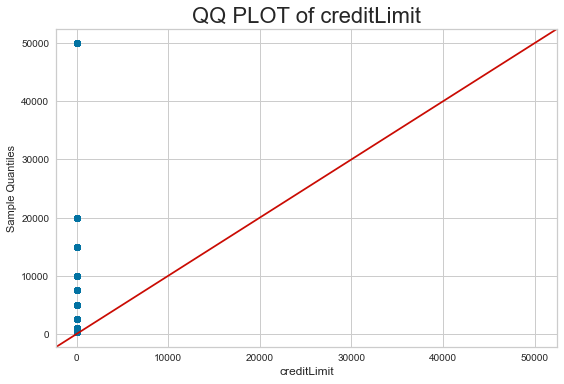

<Figure size 864x360 with 0 Axes>

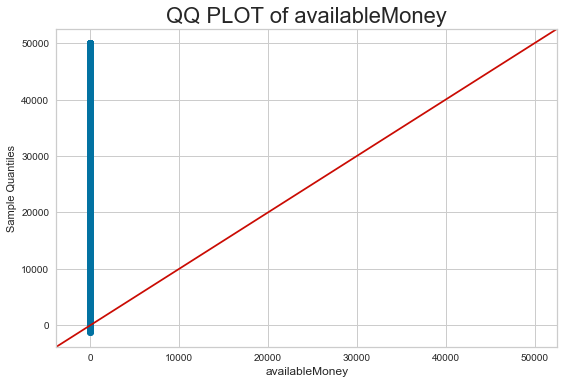

<Figure size 864x360 with 0 Axes>

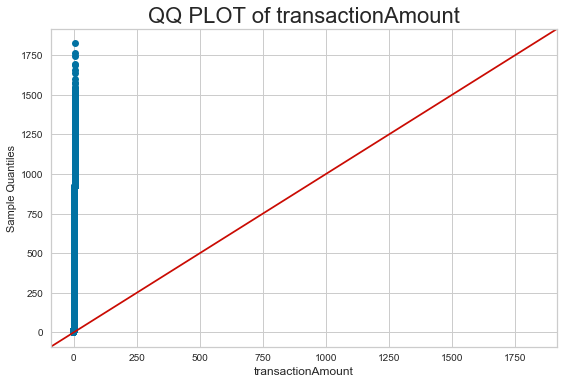

<Figure size 864x360 with 0 Axes>

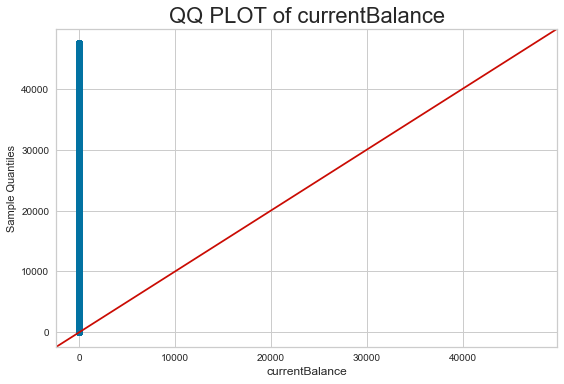

In [14]:
for i in df_con.columns :
    
    plt.figure(figsize = (12,5))
    
    sm.qqplot(df[i], line = '45')
    plt.xlabel(i, fontsize = 12)
    plt.title('QQ PLOT of ' + i, fontsize = 22)
    
    plt.tight_layout()
    plt.show()

> Sekarang kita cek outliersnya.

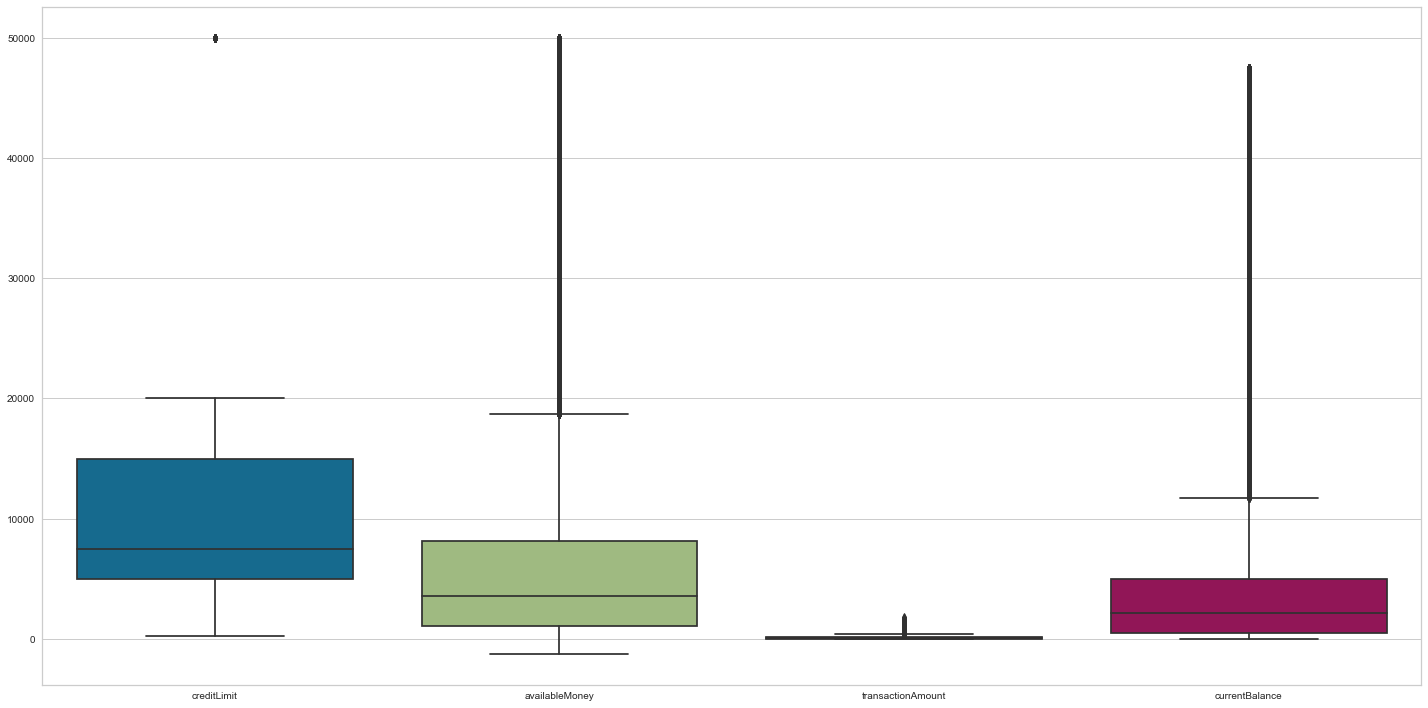

In [15]:
plt.figure(figsize = (20,10))
sns.boxplot(data=df_con)
plt.tight_layout()
plt.show()

> Terlihat sekali data memiliki banyak outliers. 

In [16]:
def outliers(df):
    Q2 = np.quantile(df, 0.50)
    Q1 = np.quantile(df, 0.25)
    Q3 = np.quantile(df, 0.75)
    
    IQR   = (Q3 - Q1) * 1.5
    lower =  Q1 - IQR
    upper =  Q3 + IQR 

    outlier = ''
    for i in range(len(df)):
        if df[i] > upper :
            outlier = outlier + str(df[i]) + ', '
        if df[i] < lower :
            outlier = outlier + str(df[i]) + ', '
    return len(outlier)

In [17]:
# Mencari outlier pada tiap features

for i in df_con.columns:
    outlier = outliers(df_con[i])
    print(f'There are {outlier} Outliers on {i} Features')

There are 263123 Outliers on creditLimit Features
There are 437167 Outliers on availableMoney Features
There are 262271 Outliers on transactionAmount Features
There are 471246 Outliers on currentBalance Features


> Terdapat ratusan ribu outlier pada tiap features. Dalam kasus semacam ini hal ini bisa saja terjadi, sehingga sepertinya tidak memungkinkan ketika di drop seluruh outliers ini. Akan lebih memungkinkan ketika kita menggunakan `RobustScaler()` nanti.

### LABELLING

> Karena seluruh data dalam categorical features kali ini tergolong data nominal, maka kita gunakan `pd.get_dummies()` untuk proses labelling nya.

In [18]:
pd.DataFrame({'dataFeatures' : df_cat.columns, 'dataType' : df_cat.dtypes.values, 
              'Nunique' : [df_cat[i].nunique() for i in df_cat.columns],
              'uniqueSample' : [list(pd.Series(df_cat[i].unique()).sample(2)) for i in df_cat.columns]}).reset_index(drop = True)

,dataFeatures,dataType,Nunique,uniqueSample
0,acqCountry,object,4,"[MEX, PR]"
1,merchantCountryCode,object,4,"[MEX, PR]"
2,posEntryMode,object,5,"[5.0, 90.0]"
3,posConditionCode,object,3,"[1.0, 8.0]"
4,merchantCategoryCode,object,19,"[mobileapps, food]"
5,transactionType,object,3,"[REVERSAL, PURCHASE]"
6,isFraud,object,2,"[No, Yes]"
7,cardPresent,object,2,"[No, Yes]"
8,expirationDateKeyInMatch,object,2,"[Yes, No]"


In [19]:
encoder = LabelEncoder()
df_cat['isFraud'] = encoder.fit_transform(df_cat[['isFraud']])

> **isFraud** features menggunakan `LabelEncoder()` karena merupakan target.

In [20]:
for i in df_cat.drop(columns = ['isFraud']):
    df_cat = pd.get_dummies(df_cat, drop_first=True)

In [21]:
df_cat.head(3)

,isFraud,acqCountry_MEX,acqCountry_PR,acqCountry_US,merchantCountryCode_MEX,merchantCountryCode_PR,merchantCountryCode_US,posEntryMode_5.0,posEntryMode_9.0,posEntryMode_80.0,...,merchantCategoryCode_online_gifts,merchantCategoryCode_online_retail,merchantCategoryCode_online_subscriptions,merchantCategoryCode_personal care,merchantCategoryCode_rideshare,merchantCategoryCode_subscriptions,transactionType_PURCHASE,transactionType_REVERSAL,cardPresent_Yes,expirationDateKeyInMatch_Yes
0,1,0,0,1,0,0,1,1,0,0,...,0,0,0,0,1,0,1,0,0,0
1,0,0,0,1,0,0,1,0,1,0,...,0,0,0,0,1,0,1,0,0,0
2,0,0,0,1,0,0,1,1,0,0,...,0,0,0,0,1,0,1,0,0,0


> Selanjutnya kita akan persiapkan data untuk di scaling. 

In [22]:
# for i in df_con.columns :
#     scaler = RobustScaler()
#     df_con[i] = scaler.fit_transform(df[[i]])

In [23]:
# Unscaled data

df_new = pd.concat([df_con, df_cat], axis = 1)

In [24]:
df_new.head(3)

,creditLimit,availableMoney,transactionAmount,currentBalance,isFraud,acqCountry_MEX,acqCountry_PR,acqCountry_US,merchantCountryCode_MEX,merchantCountryCode_PR,...,merchantCategoryCode_online_gifts,merchantCategoryCode_online_retail,merchantCategoryCode_online_subscriptions,merchantCategoryCode_personal care,merchantCategoryCode_rideshare,merchantCategoryCode_subscriptions,transactionType_PURCHASE,transactionType_REVERSAL,cardPresent_Yes,expirationDateKeyInMatch_Yes
0,5000,5000.00,111.33,0.00,1,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0
1,5000,4888.67,24.75,111.33,0,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0
2,5000,4863.92,187.40,136.08,0,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0


### FEATURE IMPORTANCES

> Feature importances atau feature / variable selection, merupakan pemilihan attribute atau subset variable yang relevan untuk digunakan pada model construction. Beberapa metode dapat dilakukan untuk melakukan feature importances ini. 

#### RECURSIVE FEATURE ELIMINATION

> Recursive feature elimination (RFE) adalah suatu metode feature selection dengan cara metode model fitting lalu mengeliminasi feature yang paling lemah. Feature tersebut di urutkan berdasarkan coefficient modelnya. RFE mencoba mengeliminasi dependencies dan collinearity yang ada pada model.

In [25]:
X = df_new.drop(['isFraud'], axis = 1)
y = df_new['isFraud']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8, random_state = 42)

In [27]:
# Select 10 best feature using RFE

model = LogisticRegression(solver = 'lbfgs', penalty = 'none', max_iter = 10)
rfe = RFE(model, n_features_to_select= 10)
rfe = rfe.fit(X_train, y_train)

# Summarize the selection of the attributes

rfe_feat = pd.Series(rfe.support_, index=X.columns)
rfe_feat[rfe_feat == True]

creditLimit                 True
availableMoney              True
transactionAmount           True
currentBalance              True
acqCountry_US               True
merchantCountryCode_US      True
posEntryMode_5.0            True
posEntryMode_9.0            True
transactionType_PURCHASE    True
cardPresent_Yes             True
dtype: bool

In [28]:
rfe_col = rfe_feat[rfe_feat == True].index
rfe_tgt = pd.DataFrame(df_new['isFraud'])

In [29]:
df_rfe = pd.concat([df_new[rfe_col], rfe_tgt], axis=1)

In [30]:
df_rfe.head(3)

,creditLimit,availableMoney,transactionAmount,currentBalance,acqCountry_US,merchantCountryCode_US,posEntryMode_5.0,posEntryMode_9.0,transactionType_PURCHASE,cardPresent_Yes,isFraud
0,5000,5000.00,111.33,0.00,1,1,1,0,1,0,1
1,5000,4888.67,24.75,111.33,1,1,0,1,1,0,0
2,5000,4863.92,187.40,136.08,1,1,1,0,1,0,0


> Kita sudah mendapatkan 10 feature yang dipilih dari metode RFE.

#### TREE BASED CLASSIFIER

> Extremely Randomized Trees Classifier(Extra Trees Classifier) adalah salah satu jenis feature importances yang menggunakan teknik Ensemble Learning. Konsepnya mirip dengan Random Forest yang meng-agregasi hasil dari beberapa de-correlated Decision Tree untuk mengeluarkan outputnya.

[3.11144075e-02 3.00087932e-01 3.38051174e-01 2.98987730e-01
 2.46435089e-04 1.91641527e-04 3.92262523e-04 2.76443747e-04
 2.00666289e-04 3.66606578e-04 3.27315200e-03 3.09203116e-03
 1.29641696e-03 1.99964003e-03 3.18314053e-03 1.45165033e-03
 6.04047037e-04 6.99920943e-05 9.89438417e-04 1.24161936e-03
 8.07676910e-04 1.49125287e-04 5.53000856e-04 3.69897279e-04
 7.34412267e-05 1.07787573e-03 7.06955370e-04 3.77653517e-04
 1.13154923e-03 1.19393418e-03 3.03856267e-04 3.98308275e-04
 1.00212432e-03 5.20280521e-04 9.52413529e-04 8.06085172e-04
 2.08160042e-03 3.77794201e-04]


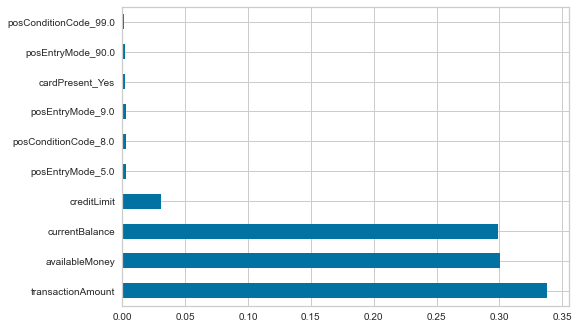

In [31]:
# feature importances using Tree Based Classifier

model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_)

# plot graph of feature importances for better visualization

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind = 'barh')
plt.show()

In [32]:
feat_col = feat_importances.nlargest(10).index.tolist()
feat_tgt = pd.DataFrame(df_new['isFraud'])

In [33]:
df_etc = pd.concat([df_new[feat_col], feat_tgt], axis=1)

In [34]:
df_etc.head(3)

,transactionAmount,availableMoney,currentBalance,creditLimit,posEntryMode_5.0,posConditionCode_8.0,posEntryMode_9.0,cardPresent_Yes,posEntryMode_90.0,posConditionCode_99.0,isFraud
0,111.33,5000.00,0.00,5000,1,0,0,0,0,0,1
1,24.75,4888.67,111.33,5000,0,0,1,0,0,0,0
2,187.40,4863.92,136.08,5000,1,0,0,0,0,0,0


> Kita juga mendapatkan 10 feature yang di pilih menggunakan Extra Tree Classifier. Sebetulnya keduanya sama saja, maka kita pilih salah satu saja.

## MODEL PREPARATION

> Di bawah ini merupakan persiapan untuk proses modelling.

In [35]:
df_ready = df_etc.copy()

In [36]:
df_ready.to_csv('transaction_HP.csv', index = False)

In [37]:
X = df_ready.drop(['isFraud'], axis=1)
y = df_ready['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

> Modelling dilakukan menggunakan pipeline dan scaling menggunakan Robust Scaler sekaligus bagi model yang menggunakan default parameter maupun model yang menggunakan hyperparameter.

In [42]:
# Default model build + pipelining

# Logistic Regression 

LRG = Pipeline([('scale', RobustScaler()),
                ('clf', LogisticRegression())])

# K-Nearest Neighbors 

KNN = Pipeline([('scale', RobustScaler()),
                ('clf', KNeighborsClassifier())])

> Tuning hyperparameter di lakukan di notebook yang terpisah. Hasil terbaik di terapkan di sini.

In [43]:
# Hyperparameter tuned model build + pipelining

# Logistic Regression 

hyper_LRG = Pipeline([('scale', RobustScaler()),
                      ('clf', LogisticRegression(solver = 'lbfgs', penalty = 'l2', max_iter = 200))])

# K-Nearest Neighbors 

hyper_KNN = Pipeline([('scale', RobustScaler()),
                      ('clf', KNeighborsClassifier(p = 2, n_neighbors = 25, leaf_size = 20))])

### MODEL FITTING

> Selanjutnya kita akan lakukan fitting model kepada data train, baik pada model default maupun model hyperparameter tuned.

In [44]:
# Default model fitting

# Logistic Regression 

LRG = LRG.fit(X_train, y_train)

# K-Nearest Neighbors 

KNN = KNN.fit(X_train, y_train)

In [45]:
# Hyperparameter tuned model fitting

# Logistic Regression 

hyper_LRG = hyper_LRG.fit(X_train, y_train)

# K-Nearest Neighbors 

hyper_KNN = hyper_KNN.fit(X_train, y_train)

### CROSS VALIDATION

> Sebelum melanjutkan proses modelling, sebaiknya kita lakukan *cross validation* terlebih dahulu untuk mengetahui apakah model benar - benar sudah fit atau terdapat overfitting maupun underfitting.

In [46]:
# Score pada train data

LRG_score_tr = LRG.score(X_train, y_train)
KNN_score_tr = KNN.score(X_train, y_train)
hyper_LRG_score_tr = hyper_LRG.score(X_train, y_train)
hyper_KNN_score_tr = hyper_KNN.score(X_train, y_train)

In [47]:
# Score pada test data

LRG_score_ts = LRG.score(X_test, y_test)
KNN_score_ts = KNN.score(X_test, y_test)
hyper_LRG_score_ts = hyper_LRG.score(X_test, y_test)
hyper_KNN_score_ts = hyper_KNN.score(X_test, y_test)

In [48]:
train_score = pd.DataFrame({'Model' : ['LogisticRegression', 'KNNeighbors'], 
                            'Normal': [LRG_score_tr, KNN_score_tr], 
                            'Hyper' : [hyper_LRG_score_tr, hyper_KNN_score_tr]})

In [49]:

test_score = pd.DataFrame({'Model' : ['LogisticRegression', 'KNNeighbors'], 
                           'Normal': [LRG_score_ts, KNN_score_ts], 
                           'Hyper' : [hyper_LRG_score_ts, hyper_KNN_score_ts]})

> `pd.concat()` untuk menampilkan score berdasarkan *accuracy*.

In [50]:
pd.concat([train_score, test_score], keys = ['Train Score', 'Test Score'])

Model    Normal     Hyper
Train Score 0  LogisticRegression  0.982878  0.982878
            1         KNNeighbors  0.982965  0.982902
Test Score  0  LogisticRegression  0.982441  0.982441
            1         KNNeighbors  0.982228  0.982472

> Berdasarkan score *accuracy* yang di tampilkan di atas, sepertinya tidak terlihat adanya overfitting. Namun untuk lebih memastikan lagi, maka kita pastikan dengan menampilkan `learning_curve()`.

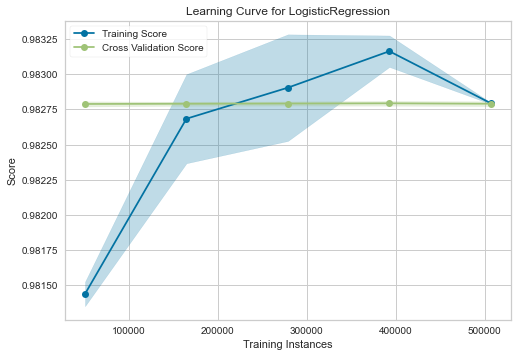

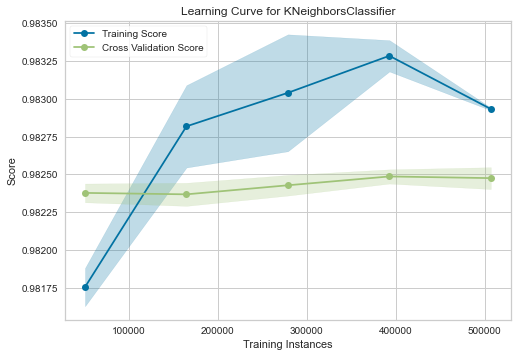

In [51]:
# Learning curve untuk default parameter

curve = [LRG, KNN]

for i in curve:
    learning_curve(i, X, y, scoring='accuracy')
    plt.show()

> Berdasarkan plot *learning curves* di atas, sepertinya model memang stabil dan tidak terdapat overfitting pada kedua model ini.

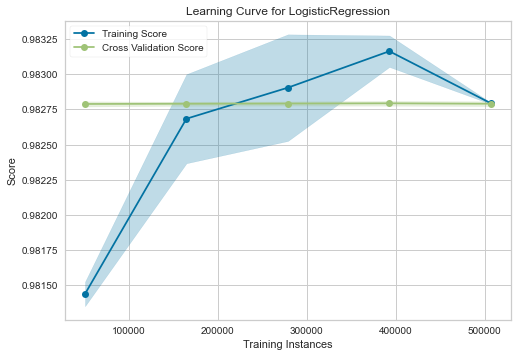

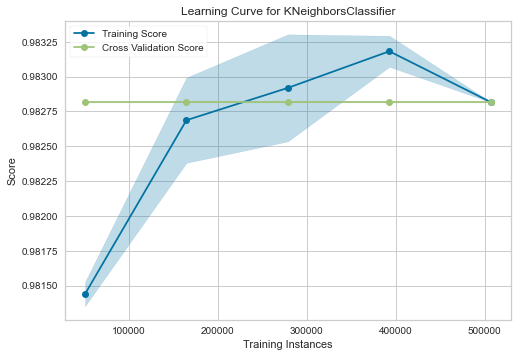

In [52]:
# Learning curve untuk tuned parameter

curve = [hyper_LRG, hyper_KNN]

for i in curve:
    learning_curve(i, X, y, scoring='accuracy')
    plt.show()

> Hasil yang sama baiknya juga di tunjukkan pada model dengan tuning hyperparameter. Sehingga dapat di simpulkan bahwa tidak terdapat overfitting pada kedua model pada kedua parameter. Detail *kfold* nya bisa di lihat di bawah ini.

In [53]:
cv = StratifiedKFold(n_splits = 10, shuffle= True, random_state=0)
LRG_kfold = cross_val_score(LRG, X_train, y_train, cv = cv, scoring = 'accuracy')
KNN_kfold = cross_val_score(KNN, X_train, y_train, cv = cv, scoring = 'accuracy')
hyper_LRG_kfold = cross_val_score(hyper_LRG, X_train, y_train, cv = cv, scoring = 'accuracy')
hyper_KNN_kfold = cross_val_score(hyper_KNN, X_train, y_train, cv = cv, scoring = 'accuracy')

pd.DataFrame({'LRG kfold' : LRG_kfold.tolist(),
              'KNN kfold' : KNN_kfold.tolist(),
              'Hyper LRG kfold' : hyper_LRG_kfold.tolist(),
              'Hyper KNN kfold' : hyper_KNN_kfold.tolist()})

,LRG kfold,KNN kfold,Hyper LRG kfold,Hyper KNN kfold
0,0.982863,0.982587,0.982863,0.982902
1,0.982863,0.982587,0.982863,0.982902
2,0.982882,0.982705,0.982882,0.982902
3,0.982902,0.982527,0.982902,0.982902
4,0.982882,0.982665,0.982882,0.982902
5,0.982863,0.982587,0.982863,0.982902
6,0.982902,0.982626,0.982902,0.982902
7,0.982862,0.982665,0.982862,0.982902
8,0.982902,0.982685,0.982902,0.982902
9,0.982862,0.982626,0.982862,0.982902


In [55]:
pd.DataFrame({'Model' : ['Random Forest', 'Support Vector'], 
              'Default' : [LRG_score_tr, KNN_score_tr],
              'Hyper': [hyper_LRG_score_tr, hyper_KNN_score_tr], 
              'Mean Kfold' : [hyper_LRG_kfold.mean(), hyper_KNN_kfold.mean()]})

,Model,Default,Hyper,Mean Kfold
0,Random Forest,0.982878,0.982878,0.982878
1,Support Vector,0.982965,0.982902,0.982902


## MODEL PREDICTION & PERFORMANCE EVALUATION

> Selanjutnya kita lakukan prediksi dan evaluasi model.

In [57]:
# Logistic Regression

yp_LRG = hyper_LRG.predict(X_test)

# KNNeighbors

yp_KNN = hyper_KNN.predict(X_test)

In [58]:
# Label untuk confusion matrix

labels = ['Fraud No', 'Fraud Yes']

### LOGISTIC REGRESSION

              precision    recall  f1-score   support

    Fraud No       0.98      1.00      0.99    124548
   Fraud Yes       0.17      0.00      0.00      2222

    accuracy                           0.98    126770
   macro avg       0.57      0.50      0.50    126770
weighted avg       0.97      0.98      0.97    126770



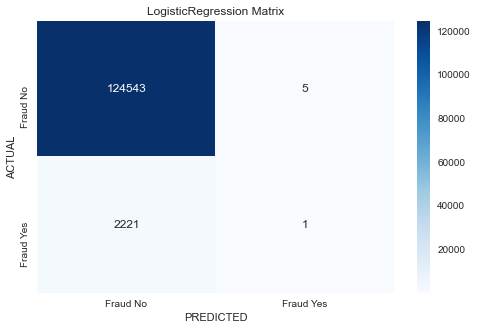

In [59]:
# LogisticRegression evaluation

print(classification_report(y_test, yp_LRG, target_names = labels))
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, yp_LRG), annot=True, fmt=".0f", ax=ax, cmap = 'Blues')

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.title('LogisticRegression Matrix')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')
plt.show()

> Melihat evaluasi model **Logistic Regression**, sepertinya masih harus di lakukan balancing data lebih lanjut.

### K-NEAREST NEIGHBORS

              precision    recall  f1-score   support

    Fraud No       0.98      1.00      0.99    124548
   Fraud Yes       0.00      0.00      0.00      2222

    accuracy                           0.98    126770
   macro avg       0.49      0.50      0.50    126770
weighted avg       0.97      0.98      0.97    126770



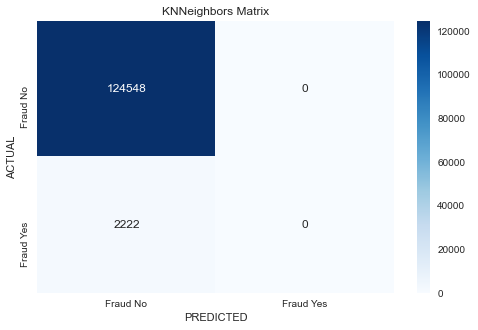

In [60]:
# KNNeighbors evaluation

print(classification_report(y_test, yp_KNN, target_names = labels))
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, yp_KNN), annot=True, fmt=".0f", ax=ax, cmap = 'Blues')

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.title('KNNeighbors Matrix')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')
plt.show()

> Dalam model **KNNeighbors** ini juga terjadi hal yang sama. Walaupun ketika kita bandingkan, kedua model sama - sama memiliki 98% *accuracy*, tetapi jika di perhatikan lagi pada ***confusion matrix*** di atas, **Logistic Regression** masih memiliki *precision* yang lebih baik daripada model **KNNeighbors**.

## OVERSAMPLING - SMOTE

> Pada dasarnya, **SMOTE** atau *Synthetic Minority Oversampling Technique*, merupakan teknik oversampling dengan cara menggunakan synthetic data yang nantinya data tersebut akan di oversampling sehingga jumlah data minoritas sama dengan data mayoritas. **SMOTE** menggunakan teknik yang sama dengan KNN - *euclidean distance based* - namun karena alasan sebelumnya, maka kita hanya akan melakukan oversampling pada model **Logistic Regression** saja. Oversampling ini di lakukan karena data imbalanced, sehingga menyulitkan model dalam proses prediksi.

In [103]:
# Oversampling dengan SMOTE

X_train_sm, y_train_sm = SMOTE(random_state=101).fit_sample(X_train, y_train)

# Model best porameter - oversampled

LRG_sm = LogisticRegression(solver = 'lbfgs', penalty = 'l2', max_iter = 200).fit(X_train_sm, y_train_sm)

In [104]:
# Predict dengan Logistic Regression - oversampled

yp_LRG_sm = LRG_sm.predict(X_test)

              precision    recall  f1-score   support

    Fraud No       0.99      0.82      0.90    124548
   Fraud Yes       0.04      0.42      0.07      2222

    accuracy                           0.81    126770
   macro avg       0.51      0.62      0.48    126770
weighted avg       0.97      0.81      0.88    126770



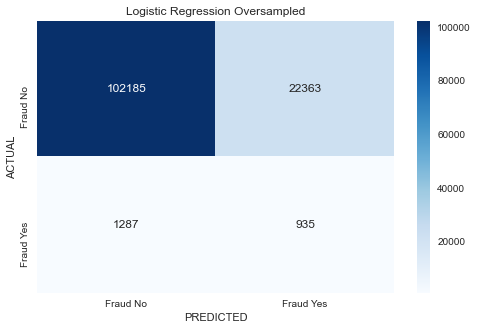

In [105]:
# Model evaluation

print(classification_report(y_test, yp_LRG_sm, target_names = labels))
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, yp_LRG_sm), annot=True, fmt=".0f", ax=ax, cmap = 'Blues')

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.title('Logistic Regression Oversampled')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')
plt.show()

> Setelah dilakukan *oversampling*, memang jelas tampak bahwa model menjadi lebih baik daripada sebelumnya. Dan pada akhirnya, model **Logistic Regression** dengan *scaling* menggunakan **Robust Scaler** dan teknik *oversampling* dengan **SMOTE**, menjadi model yang paling baik untuk digunakan dalam data ini. 

> Pada intinya, model ini memiliki 81% *accuracy*, memiliki 99% *precision* pada kategori yang **tidak fraud**. Terlebih lagi, model ini juga memiliki *recall* yang cukup tinggi pada kategori yang **tidak fraud**, model dapat memprediksi dengan benar sekitar 82% pada kategori ini, walaupun pada kategori yang **fraud** masih hanya sekitar 42%. Tetapi bagaimanapun juga versi model ini sudah lebih baik dan seimbang di bandingkan dengan versi sebelum di lakukan *balancing*.